LIB


In [ ]:
import glob # kiet ke batch chua buc anh
#import os.path as osp
import os
import random
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn # thu vien de viet model
import torch.optim as optim  # chua thuat toan: Adam...
import torch.utils.data as data # chua ham so dieu khien data
from torch.utils.data import random_split
import torchvision
from torchvision import models, transforms, datasets# goi models da train tren imageNet
from tqdm import tqdm

CONNECT DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Kiểm tra xem có GPU CUDA nào khả dụng không
# cuda_available = torch.cuda.is_available()

# Nếu có, thiết lập biến này để sử dụng GPU
# device = torch.device("cuda" if cuda_available else "cpu")


torch.manual_seed(1234) # co dinh ngau nhien chay trong may
np.random.seed(1234)
random.seed(1234)

TRANSFORMS

In [ ]:
# train
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale = (0.5, 1.0)), #cat it nhat 1 nua -> resize
    transforms.RandomHorizontalFlip(), # xac suat co the xoay anh theo chieu ngang
    transforms.ToTensor(), # chuyen ve tensor
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std =[0.229, 0.224, 0.225] ),

            ])
#val
val_transforms = transforms.Compose([
    transforms.Resize(255),  # kich thuoc mong muon
    transforms.CenterCrop(224),
    transforms.ToTensor(), # chuyen ve tensor
    transforms.Normalize(mean =[0.485, 0.456, 0.406] , std= [0.229, 0.224, 0.225])

            ])
#test
test_transforms = transforms.Compose([
    transforms.Resize(255),  # kich thuoc mong muon
    transforms.CenterCrop(224),
    transforms.ToTensor(), # chuyen ve tensor
    transforms.Normalize(mean =[0.485, 0.456, 0.406] , std= [0.229, 0.224, 0.225])
])


**TRAIN_DATASET & TEST_DATASET**

In [ ]:
data_path_train = r'/content/gdrive/MyDrive/dogcat/chomeo/train/'
data_path_test = r'/content/gdrive/MyDrive/dogcat/chomeo/test/'

train_dataset = datasets.ImageFolder(data_path_train + 'train', transform = train_transforms)
test_dataset = datasets.ImageFolder(data_path_test + 'test', transform = test_transforms)

In [ ]:
print(len(train_dataset))
print(len(test_dataset))

12005
2023


**CHIA DU LIEU TRAIN**

In [ ]:
val_size = int(len(train_dataset) * 0.2)
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
print(len(train_ds)), print(len(val_ds))

9604
2401


(None, None)

**TRAIN_DATALOADER, TEST_DATALOADER, VAL_DATALOADER**

In [ ]:
    train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size = 6, shuffle = True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 6)
    val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=6)

**DATASET**

In [ ]:
class MyDataset(data.Dataset):
    def init(self, file_list, transform = None, phase = 'train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
# dem so luong file
    def __len__(self):
        return len(self.file_list)
# lay ra FILE
    def getitem(self, idx):  #idx: anh thu bao nhieu trong file
        img_path = self.file_list[idx]
        img = Image.open(img_path)

        img_transformed = self.transform(img, self.phase)

        if self.phase  == 'train':
            label = img_path[23:27]
        elif self.phase == 'val':
            label = img_path[21:25]

        if label == "cats":
            label = 0
        elif label == 'dogs':
            label = 1

        return img_transformed, label


In [ ]:
idx = 0
img , label = train_dataset[idx]
print(img.shape)
print(label)

torch.Size([3, 224, 224])
0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


0


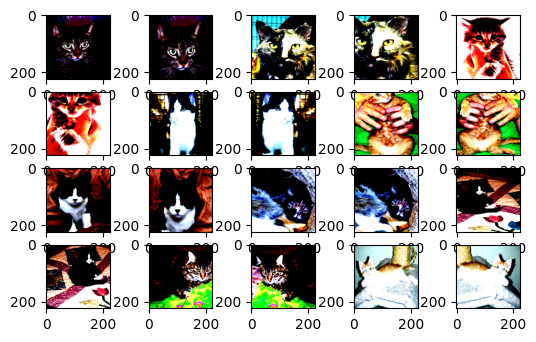

In [ ]:
idx = 0
for idx in range(20):
    img_tensor,label = train_dataset[idx]

    img_numpy = np.transpose(img_tensor, (1,2,0))

    plt.subplot(5, 5, idx + 1)
    plt.imshow(img_numpy)

    print(label)




**MODEL VGG**

In [ ]:
'''use_pretrained = True
model = models.vgg16(pretrained=use_pretrained)
model.classifier[6] = nn.Linear(in_features=4096, out_features=2)
print(model)

# setting mode
model = model.cuda()
model = model.train();'''

class VGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16, self).__init__()
        # Define the layers of VGG16
        self.features = nn.Sequential(
            # class_1
            nn.Conv2d(3, 64, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3,stride = 1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(),
            # class_2
            nn.Conv2d(64, 128, kernel_size=3,stride = 1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3,stride =1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # class_3
            nn.Conv2d(128, 256, kernel_size=3,stride = 1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3,stride =1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        # Define the classifier part of VGG16
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7,512 ),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        # Forward pass through the feature extractor
        x = self.features(x)
        x=self.avgpool(x)
        # Flatten the output for the classifier
        x = torch.flatten(x, start_dim=1)

        # Forward pass through the classifier
        x = self.classifier(x)
        return x

# Instantiate the VGG16 model
model = VGG16(num_classes=2)  # Example for 10 classes

# Print the model
print(model)
# setting mode

# setting mode
model = model.train();

# model = model.to(device)


VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
   

**LOSS AND OPTIMIZER**

In [ ]:
criterior = nn.CrossEntropyLoss()

model = VGG16(num_classes = 2)
params_to_update = model.parameters()


optimizer = optim.SGD(params=params_to_update , lr=1e-3, momentum=0.9)

**TRAIN MODEL**

In [ ]:
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}
def train_model(num_epoch,dataloader_dict,model, criterior, optimizer):
      for epoch in range(num_epoch):
        print("Epoch {}/{}".format(epoch, num_epoch))

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            if (epoch == 0) and (phase == "train"):
                continue
            for inputs, labels in tqdm(dataloader_dict[phase]):
                # inputs = inputs.to(device)
                # labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):

                    outputs = model(inputs)
                    loss = criterior(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item()*inputs.size(0) # loss của cả quá trình
                    epoch_corrects += torch.sum(preds==labels.data)  # chính xác của cả quá trình

            if len(dataloader_dict[phase].dataset) == 0:
                epoch_loss = 0.0
                epoch_accuracy = 0.0
            else:
                epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset) # loss trên 1 lần epoch
                epoch_accuracy = epoch_corrects.double() / len(dataloader_dict[phase].dataset) # chính xác trên 1 lần epoch

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_accuracy))




In [ ]:
num_epoch = 3
train_model(num_epoch,dataloader_dict, model, criterior, optimizer)


In [ ]:
def test( model, criterior):
    model.eval()

    loss_test = 0
    corrects_test = 0

    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs_test = model(inputs)
        loss = criterior(outputs_test, labels)
        _, preds = torch.max(outputs_test, 1) # du doan nhan

        loss_test += loss.item()*inputs.size(0) # loss của cả quá trình
        corrects_test += torch.sum(preds==labels.data)

        if len(test_dataset) == 0:
            loss_test = 0.0
            accuracy_test = 0.0
        else:
            loss_test = loss_test / len(test_dataloader.dataset) # loss trên 1 lần epoch
            accuracy_test = corrects_test.double() / len(test_dataloader.dataset)
    print("Test Loss: {:.4f} Acc: {:.4f}".format(loss_test, accuracy_test))


test( model, criterior)